## Read Text Captions ##

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

Using TensorFlow backend.


In [2]:
def readTextFile(path):
    with open(path) as f:
        captions=f.read()
    return captions    

In [3]:
captions=readTextFile("./Data/Flickr_TextData/Flickr8k.token.txt")
captions=captions.split("\n")[:-1]

In [4]:
captions[5]

'1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting'

In [5]:
len(captions)

40460

### dictionary to map each Image with the list of captions ###

In [6]:
descriptions={}
for caption in captions:
    key,value=caption.split('\t')
    key=key.split('.')[0]
    
    #if the image id is already present or not
    if descriptions.get(key) is None:
        descriptions[key]=[]
    descriptions[key].append(value)    

In [7]:
descriptions["1001773457_577c3a7d70"]

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

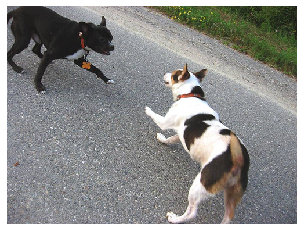

In [8]:
IMG_PATH="Data/Images/"

import cv2
import matplotlib.pyplot as plt

img=cv2.imread(IMG_PATH+"1001773457_577c3a7d70.jpg")
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()



## Data Cleaning ##

In [9]:
def clean_text(caption):
    caption=caption.lower()
    caption=re.sub("[^a-z]+"," ",caption)
    caption=caption.split()
    
    caption=[s for s in caption if len(s)>1]
    caption=" ".join(caption)
    return caption

In [10]:
clean_text("are you there? #45")

'are you there'

In [11]:
#clean all captions
for captions in descriptions.values():
    for i in range(len(captions)):
        
        captions[i]=clean_text(captions[i])

In [12]:
descriptions["1001773457_577c3a7d70"]

['black dog and spotted dog are fighting',
 'black dog and tri colored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

In [13]:
#write The data to text file
f=open("descriptions.txt","w")
f.write(str(descriptions))
f.close()

## Create Vocab ##

In [14]:
descriptions=None
with open("descriptions.txt") as f:
    descriptions=f.read()
   

In [15]:
json_acceptable_string=descriptions.replace("'","\"")
descriptions=json.loads(json_acceptable_string)

In [16]:
print(len(descriptions))

8092


In [17]:
for i in descriptions.items():
    print(i)
    break

('1000268201_693b08cb0e', ['child in pink dress is climbing up set of stairs in an entry way', 'girl going into wooden building', 'little girl climbing into wooden playhouse', 'little girl climbing the stairs to her playhouse', 'little girl in pink dress going into wooden cabin'])


In [18]:
#Vocab
vocab=set()
for key in descriptions.keys():
     [vocab.update(sentence.split()) for sentence in descriptions[key]]
    

In [19]:
print("Vocabulary size:%d" %len(vocab))

Vocabulary size:8424


In [20]:
#Total No of Words across all the sentences
total_words=[]

for key in descriptions.keys():
    [total_words.append(word) for caption in descriptions[key] for word in caption.split()]
    
print("Total Words %d"%len(total_words))    

Total Words 373837


In [21]:
#filter words from the vocab according to the certain threshold frequency

import collections

counter=collections.Counter(total_words)
freq_cnt=dict(counter)
#print(freq_cnt)

In [22]:
#sort this dictionary according to the frequency count in reverse order
sorted_freq_cnt=sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])
print(type(sorted_freq_cnt))

#Filter Top words
threshold=10
sorted_freq_cnt=[x for x in sorted_freq_cnt if x[1]>=threshold]
total_words=[x[0] for x in sorted_freq_cnt]


<class 'list'>


In [23]:
print(type(freq_cnt.items()))

<class 'dict_items'>


In [24]:
print(len(total_words)) ##final Vocab Size

1956


## Prepare Train/Test Data ##

In [25]:
#Here we have to create descriptions for training data
train_file_data=readTextFile("Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data=readTextFile("Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [26]:
train=[img_id.split(".")[0] for img_id in train_file_data.split("\n")[:-1]]
test=[img_id.split(".")[0] for img_id in test_file_data.split("\n")[:-1]]

In [27]:
print(train[:8])

['2513260012_03d33305cf', '2903617548_d3e38d7f88', '3338291921_fe7ae0c8f8', '488416045_1c6d903fe0', '2644326817_8f45080b87', '218342358_1755a9cce1', '2501968935_02f2cd8079', '2699342860_5288e203ea']


In [29]:
#Prepare Description for the training Data
#Add <s> and <e> tiken to our training data
train_descriptions={}

for img_id in train:
    train_descriptions[img_id]=[]
    for caption in descriptions[img_id]:
        cap="startseq "+ caption +" endseq"
        train_descriptions[img_id].append(cap)

In [30]:
train_descriptions["1001773457_577c3a7d70"]

['startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

## Transfer Learning ##

## Step-1 Image Feature Extraction ##

In [31]:
model=ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

102858752/102853048 [==============================] - 44s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
_______________________

In [32]:
model_new=Model(model.input,model.layers[-2].output)

### PreProcess Image ###

In [43]:
def preprocess_img(img):
    img=image.load_img(img,target_size=(224,224))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0)
    #Normalization
    img=preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


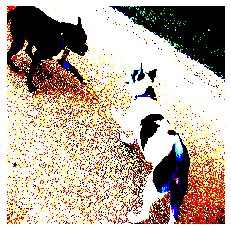

In [47]:

img=preprocess_img(IMG_PATH+"1001773457_577c3a7d70.jpg")

plt.imshow(img[0])
plt.axis("off")
plt.show()


In [59]:
def encode_image(img):
    img=preprocess_img(img)
    feature_vector=model_new.predict(img)
    feature_vector=feature_vector.reshape((-1,))
    
    #print(feature_vector.shape)
    
    return feature_vector
    

In [60]:
encode_image(IMG_PATH+"1001773457_577c3a7d70.jpg")

array([0.7313729 , 0.69773555, 0.06338634, ..., 0.06444145, 0.6066637 ,
       0.15467261], dtype=float32)

In [61]:
start=time()
encoding_train={}

#image_id --> feature_vector extracted from Resnet Image
for idx,img_id in enumerate(train):
    img_path=IMG_PATH+img_id+".jpg"
    encoding_train[img_id]=encode_image(img_path)
    
    if idx%100==0:
        print("Encoding in Progress Time step %d"%idx)
        
end_t=time()

print("Total Time Taken :",end_t-start)
        
    

Encoding in Progress Time step 0
Encoding in Progress Time step 100
Encoding in Progress Time step 200
Encoding in Progress Time step 300
Encoding in Progress Time step 400
Encoding in Progress Time step 500
Encoding in Progress Time step 600
Encoding in Progress Time step 700
Encoding in Progress Time step 800
Encoding in Progress Time step 900
Encoding in Progress Time step 1000
Encoding in Progress Time step 1100
Encoding in Progress Time step 1200
Encoding in Progress Time step 1300
Encoding in Progress Time step 1400
Encoding in Progress Time step 1500
Encoding in Progress Time step 1600
Encoding in Progress Time step 1700
Encoding in Progress Time step 1800
Encoding in Progress Time step 1900
Encoding in Progress Time step 2000
Encoding in Progress Time step 2100
Encoding in Progress Time step 2200
Encoding in Progress Time step 2300
Encoding in Progress Time step 2400
Encoding in Progress Time step 2500
Encoding in Progress Time step 2600
Encoding in Progress Time step 2700
Enco

In [62]:
#store everything to the disk

with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [63]:
start=time()
encoding_test={}

#image_id --> feature_vector extracted from Resnet Image
for idx,img_id in enumerate(test):
    img_path=IMG_PATH+img_id+".jpg"
    encoding_train[img_id]=encode_image(img_path)
    
    if idx%100==0:
        print("Test Encoding in Progress Time step %d"%idx)
        
end_t=time()

print("Total Time Taken(test) :",end_t-start)
        

Test Encoding in Progress Time step 0
Test Encoding in Progress Time step 100
Test Encoding in Progress Time step 200
Test Encoding in Progress Time step 300
Test Encoding in Progress Time step 400
Test Encoding in Progress Time step 500
Test Encoding in Progress Time step 600
Test Encoding in Progress Time step 700
Test Encoding in Progress Time step 800
Test Encoding in Progress Time step 900
Total Time Taken(test) : 323.4342381954193


In [64]:
with open("encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)